In [2]:
import os
import sys
import glob
import scipy
import sklearn
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_rows', 100)
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42
pd.set_option('display.max_columns', 100)

sns.set_palette("Set2")


In [3]:
data_loc = '/home/mattolm/user_data/IndianMicrobiome/tables/'

In [4]:
import io
import boto3

def get_matching_s3_objects(bucket, prefix="", suffix=""):
    """
    Generate objects in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch objects whose key starts with
        this prefix (optional).
    :param suffix: Only fetch objects whose keys end with
        this suffix (optional).
    """
    s3 = boto3.client("s3")
    paginator = s3.get_paginator("list_objects_v2")

    kwargs = {'Bucket': bucket}

    # We can pass the prefix directly to the S3 API.  If the user has passed
    # a tuple or list of prefixes, we go through them one by one.
    if isinstance(prefix, str):
        prefixes = (prefix, )
    else:
        prefixes = prefix

    for key_prefix in prefixes:
        kwargs["Prefix"] = key_prefix

        for page in paginator.paginate(**kwargs):
            try:
                contents = page["Contents"]
            except KeyError:
                return

            for obj in contents:
                key = obj["Key"]
                if key.endswith(suffix):
                    yield obj


def get_matching_s3_keys(bucket, prefix="", suffix=""):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    :param suffix: Only fetch keys that end with this suffix (optional).
    """
    for obj in get_matching_s3_objects(bucket, prefix, suffix):
        yield obj["Key"]
        
def check_s3_file(floc):
    '''
    Return True if exists and False if it does not
    '''
    bucket = floc.split('/')[2]
    prefix = '/'.join(floc.split('/')[3:])
    
    found = False
    for key in get_matching_s3_keys(bucket, prefix):
        if prefix in key:
            found = True
    return found

def store_s3_file(bucket, location, binary_string):
    s3 = boto3.resource('s3')
    object = s3.Object(bucket, location)
    object.put(Body=binary_string)
    
def load_coverage_report(s3_bucket, s3_key, sep='\t', names=None):
    '''
    https://towardsdatascience.com/web-scraping-html-tables-with-python-c9baba21059
    '''
    # Load the data from s3
    client = boto3.client("s3")
    obj = client.get_object(Bucket=s3_bucket, Key=s3_key)
    df = pd.read_csv(io.BytesIO(obj['Body'].read()), sep=sep, names=names)

    return df

def load_coverage_report2(s3_loc, sep='\t', names=None):
    '''
    https://towardsdatascience.com/web-scraping-html-tables-with-python-c9baba21059
    '''
    s3_bucket = s3_loc.split('/')[2]
    s3_key = '/'.join(s3_loc.split('/')[3:])
    
    # Load the data from s3
    client = boto3.client("s3")
    obj = client.get_object(Bucket=s3_bucket, Key=s3_key)
    df = pd.read_csv(io.BytesIO(obj['Body'].read()), sep=sep, names=names)

    return df
    
def read_s3_file(s3_bucket, s3_key):
    s3 = boto3.resource('s3')
    obj = s3.Object(s3_bucket, s3_key)
    return obj.get()['Body'].read().decode("utf-8")

def object_size(s3_bucket, s3_key):    
    return boto3.resource('s3').Bucket(s3_bucket).Object(s3_key).content_length

def object_size2(s3_loc):
    s3_bucket = s3_loc.split('/')[2]
    s3_key = '/'.join(s3_loc.split('/')[3:])
    
    return boto3.resource('s3').Bucket(s3_bucket).Object(s3_key).content_length
    
def read_s3_file2(s3_loc):
    s3 = boto3.resource('s3')
    bucket = s3_loc.split('/')[2]
    key = '/'.join(s3_loc.split('/')[3:])
    return read_s3_file(bucket, key)

def store_s3_file2(s3_loc, binary_string):
    s3 = boto3.resource('s3')
    bucket = s3_loc.split('/')[2]
    key = '/'.join(s3_loc.split('/')[3:])
    return store_s3_file(bucket, key, binary_string)

## Find read locs

In [9]:
table = defaultdict(list)

base_loc = 's3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/'
for r1 in get_matching_s3_keys('czbiohub-microbiome', 'Sonnenburg_Lab/2021_Indian_Microbiome/'):
    table['s3_loc'].append('s3://czbiohub-microbiome/' + r1)

PPdb = pd.DataFrame(table)


In [26]:
pd.set_option('display.max_colwidth', None)

Pdb = PPdb.copy()
Pdb['filename'] = [os.path.basename(x) for x in Pdb['s3_loc']]
Pdb['sample'] = [x.split('_R1')[0].split('_R2')[0] for x in Pdb['filename']]

# Split out read1 and read2; merge them back
Pdb['read'] = [x.split('_')[-1].split('.')[0] for x in Pdb['filename']] 
db1 = Pdb[Pdb['read'] == 'R1'].rename(columns={'s3_loc':'read1'})
del db1['filename']
del db1['read']
db2 = Pdb[Pdb['read'] == 'R2'].rename(columns={'s3_loc':'read2'})
del db2['filename']
del db2['read']
Pdb = pd.merge(db1, db2, on='sample')
Pdb = Pdb[['sample', 'read1', 'read2']]

Pdb.head()


sample  \
0  LibPlate-A10_AK-SR-5   
1  LibPlate-A12_AK-SR-6   
2  LibPlate-A14_AK-SR-7   
3  LibPlate-A16_AK-SR-8   
4  LibPlate-A18_AK-SR-9   

                                                                                             read1  \
0  s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A10_AK-SR-5_R1.fastq.gz   
1  s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A12_AK-SR-6_R1.fastq.gz   
2  s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A14_AK-SR-7_R1.fastq.gz   
3  s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A16_AK-SR-8_R1.fastq.gz   
4  s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A18_AK-SR-9_R1.fastq.gz   

                                                                                             read2  
0  s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A10_AK-SR-5_R2.fastq.gz  
1  s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A12_AK-SR-6_R2.fastq.gz  
2  s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A14_AK-SR-7_R2.fastq.gz  
3  s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A16_AK-SR-8_R2.fastq.gz  
4  s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A18_AK-SR-9_R2.fastq.gz

## Load metadata

In [86]:
Mdb1 = pd.read_excel(data_loc + 'AK_Tribal Stool_DNA Quantification.xlsx', sheet_name='Fecal samples')
Mdb1 = Mdb1[['Sample_ID', 'ng/ul', 'Tribe']].rename(columns={'ng/ul':'DNA_concentration'})
Mdb2 = pd.read_excel(data_loc + 'AK_Tribal Stool_DNA Quantification.xlsx', sheet_name='Enrichment samples').rename(columns={'Sample ID':'Sample_ID', 'Fecal Sample':'Fecal_sample'})
Mdb2 = Mdb2[['Sample_ID', 'Tribe', 'Fecal_sample']]
Mdb = pd.concat([Mdb1, Mdb2]).reset_index(drop=True)
Mdb = Mdb.rename(columns={'Sample_ID':'sample_ID', 'Tribe':'tribe', 'Fecal_sample':'fecal_sample'})

# Specific edits
Mdb['sample_ID'] = [x if x != 'AK_SK_35*' else 'AK_SK_35' for x in Mdb['sample_ID']]
Mdb.loc[11, 'sample_ID'] = 'AK_SR_10.2'
Mdb.loc[38, 'sample_ID'] = 'AK_SG_8.2'

assert len(Mdb[Mdb['sample_ID'].duplicated(keep=False)]) == 0
Mdb.to_csv(data_loc + 'IndianMetadata_raw_v1.csv', index=False)
Mdb.head()


sample_ID  DNA_concentration  tribe fecal_sample
0    AK_SR_1               51.5  Kabui          NaN
1    AK_SR_2               28.7  Kabui          NaN
2  AK_SR_2.2               92.8  Kabui          NaN
3    AK_SR_3              411.8  Kabui          NaN
4    AK_SR_4               83.3  Kabui          NaN

## Merge

In [90]:
PPdb = Pdb.copy()
PPdb['sample_ID'] = [x.split('_')[1].replace('-', '_') for x in PPdb['sample']]
PPdb['sample_ID'] = [x[:-2] + '.2' if ((x[-2:] == '_2') & (x.count('_') == 3)) else x for x in PPdb['sample_ID']]

# Specific edits
PPdb.loc[49, 'sample_ID'] = 'AK_SR_10.2'

assert len(PPdb[PPdb['sample_ID'].duplicated(keep=False)]) == 0
assert set(PPdb['sample_ID']) == set(Mdb['sample_ID'])

PPdb = pd.merge(PPdb, Mdb, how='right')
PPdb['sample_type'] = ['fecal' if fs != fs else 'enrichment' for fs in PPdb['fecal_sample']]
PPdb = PPdb.rename(columns={'sample':'library_key', 'sample_ID':'sample'})
PPdb = PPdb[['sample', 'read1', 'read2', 'library_key', 'tribe', 'DNA_concentration', 'sample_type', 'fecal_sample']]

assert len(PPdb) == len(Pdb) == len(Mdb)

PPdb.to_csv(data_loc + 'IndianMicrobiome_basicinfo_v1.csv', index=False)
PPdb


sample  \
0      AK_SR_1   
1      AK_SR_2   
2    AK_SR_2.2   
3      AK_SR_3   
4      AK_SR_4   
5      AK_SR_5   
6      AK_SR_6   
7      AK_SR_7   
8      AK_SR_8   
9      AK_SR_9   
10    AK_SR_10   
11  AK_SR_10.2   
12     AK_SW_1   
13     AK_SW_2   
14     AK_SW_3   
15     AK_SW_4   
16     AK_SW_5   
17     AK_SW_7   
18     AK_SW_8   
19     AK_SW_9   
20    AK_SW_11   
21    AK_SW_12   
22    AK_SW_14   
23     AK_SG_7   
24    AK_SG_10   
25    AK_SG_11   
26    AK_SG_16   
27    AK_SG_17   
28    AK_SG_19   
29    AK_SG_20   
30    AK_SG_22   
31    AK_SG_25   
32    AK_SG_26   
33    AK_SG_29   
34     AK_SG_2   
35     AK_SG_4   
36     AK_SG_5   
37     AK_SG_8   
38   AK_SG_8.2   
39     AK_SG_9   
40    AK_SG_12   
41    AK_SG_15   
42    AK_SG_18   
43    AK_SG_28   
44    AK_SK_10   
45    AK_SK_19   
46    AK_SK_32   
47    AK_SK_35   
48    AK_SK_44   
49     AK_SK_1   
50    AK_SK_11   
51    AK_SK_12   
52    AK_SK_13   
53    AK_SK_15   
54    AK_SK_24   
55    AK_SK_30   
56    AK_SK_33   
57    AK_SK_37   
58  AK_SK_49.2   
59     AK_SK_2   
60    AK_SK_18   
61    AK_SK_25   
62    AK_SK_26   
63    AK_SK_27   
64    AK_SK_38   
65    AK_SK_39   
66    AK_SK_45   
67    AK_SK_48   
68    AK_SK_49   
69     AK_SK_9   
70    AK_SK_14   
71    AK_SK_29   
72    AK_SK_34   
73    AK_SK_36   
74    AK_SK_47   
75  AK_SK_47.2   
76     AK_SK_8   
77    AK_SK_40   
78    AK_SK_17   
79     AK_SK_5   
80       RS1_A   
81       RS1_B   
82       RS5_A   
83       RS5_B   
84       RS8_A   
85       RS8_B   
86      RS12_A   
87      RS12_B   
88      RS14_A   
89      RS14_B   
90       TS1_A   
91       TS1_B   
92       TS5_A   
93       TS5_B   
94       TS8_A   
95       TS8_B   
96      TS12_A   
97      TS12_B   
98      TS14_A   
99      TS14_B   

                                                                                                read1  \
0      s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A2_AK-SR-1_R1.fastq.gz   
1      s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A4_AK-SR-2_R1.fastq.gz   
2    s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-D2_AK-SR-2-2_R1.fastq.gz   
3      s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A6_AK-SR-3_R1.fastq.gz   
4      s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A8_AK-SR-4_R1.fastq.gz   
5     s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A10_AK-SR-5_R1.fastq.gz   
6     s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A12_AK-SR-6_R1.fastq.gz   
7     s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A14_AK-SR-7_R1.fastq.gz   
8     s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A16_AK-SR-8_R1.fastq.gz   
9     s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A18_AK-SR-9_R1.fastq.gz   
10   s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A20_AK-SR-10_R1.fastq.gz   
11    s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-H2_AK-SR-10_R1.fastq.gz   
12     s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-B2_AK-SW-1_R1.fastq.gz   
13     s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-C2_AK-SW-2_R1.fastq.gz   
14     s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-C4_AK-SW-3_R1.fastq.gz   
15     s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-C6_AK-SW-4_R1.fastq.gz   
16     s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-C8_AK-SW-5_R1.fastq.gz   
17    s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-C10_AK-SW-7_R1.fastq.gz   
18    s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-C12_AK-SW-8_R1.fastq.gz   
19    s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-C14_AK-SW-9

# Run pre-processing

In [91]:
def submit_aegea_job(cmd, expected_output, rdb=None, alocation=None, verbose=False):
    """
    Submit the cmd to aegea, capture the jobID, and store the jobID at ~/aegea_logs.txt
    
    v1.0 - 1/26/21
    
    aegea 2.6.9
    """
    from datetime import datetime
    import subprocess
    
    if alocation is None:
        alocation = '/home/mattolm/.aegea_logs.txt'
    
    #1) Check it output already exists
    if check_s3_file(result):
        if verbose:
            print(f"{result} already exists")
        return None
    
    #2) Check if job is already running
    
    # Get list of running jobs
    if rdb is None:
        rdb = load_running_aegea(verbose=False)
    running_jobs = set(rdb[rdb['job_status'].isin(['RUNNING', 'RUNNABLE', 'STARTING'])]['job_ID'].tolist())
    if verbose:
        print(f"{len(running_jobs)} jobs are running")
    
    
    # Get output -> job key
    adb = pd.read_csv(alocation, sep='\t', names=['job_ID', 'output', 'time', 'cmd'])
    cdb = adb[adb['output'] == expected_output]
    if len(cdb) > 0:
        db = cdb[cdb['job_ID'].isin(running_jobs)]
    else:
        db = pd.DataFrame()
    if verbose:
        print(f"Captured {len(adb)} aegea logs, {len(running_jobs)} running jobs, {len(cdb)} previous attempts, {len(db)} currently running attempts")
    
    if len(db) > 0:
        if verbose:
            print(f"{expected_output} is currently running (job={db['job_ID'].tolist()})")
        return None
    
    # 3) Run job
    out = subprocess.check_output(cmd, shell=True, text=True)
    ID = eval(out)['jobId']
    
    # 4) Store job ID
    now = datetime.now()
    dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
    with open(alocation, 'a') as o:
        o.write(f"\n{ID}\t{expected_output}\t{dt_string}\t{cmd}")
        
    # 5) Finish
    if verbose:
        print(f"Job {ID} is launched to create {expected_output}")
    return ID

def load_running_aegea(queue="sonnenburg__spot100", tries=20, verbose=True):
    """
    Return a list of running aegea jobs
    
    v1.1 - 3/15/21
    * Better printing of status while running showq
    
    v1.0 - 1/26/21
    
    aegea 2.6.9
    """
    import subprocess
    print("Running showq...")
    while tries >= 0:
        try:
            raw_out = subprocess.check_output(f"aegea batch ls --queue {queue}", shell=True, text=True)
            break
        except:
            #print(f"showq failed for {queue}, try # {tries}")
            tries = tries - 1
    print("Showq succeeded")

    table = {'job_ID':[], 'job_status':[], 'image':[]}
    lines = len(raw_out.split('\n'))
    for j, line in enumerate(raw_out.split('\n')):
        # Skip header
        if j >= 3:
            
            lw = line.strip().split('│')
            
            # Skip weird lines
            if len(lw) != 14:
                continue
            
            table['job_ID'].append(lw[1].strip())
            table['job_status'].append(lw[4].strip())
            table['image'].append(lw[8].strip())

    db = pd.DataFrame(table)
    
    if verbose:
        print(f"{len(db[db['job_status'] == 'RUNNING'])} aegea jobs are currently running")
    
    return db


In [100]:
def make_Preprocess_command(sample, reads_prefix, reads, out_loc, **kwargs):
    """
    echo "Preprocessing Hadza_MoBio_H_A_1_1111 ..." 2>&1 | tee -a AEGEA.log
    aegea batch submit --queue sonnenburg__spot100 --retry-attempts 3     \
    --image sonnenburglab/preprocess_metagenome_reads:latest     --storage /mnt=500     \
    --vcpus 16     --memory 64000     \
    --command="export coreNum=16; \
    export mem_mb=64000; \
    export SNAKEFILE=Snakefile; \
    export CONFIG=config.yaml; \
    export HOST_INDEX_PATH=s3://czbiohub-microbiome/Sonnenburg_Lab/Fiber_Study_Reference_Data/human_index/; \
    export SAMPLE=Hadza_MoBio_H_A_1_1111; \
    export READS_PREFIX=Hadza_MoBio_H_A_1_1111; \
    export READPATHS=(s3://czb-seqbot/fastqs/191028_A00111_0391_BHVV2VDSXX/Allison_Weakley/Dylan_Dahan s3://czb-seqbot/fastqs/191125_A00111_400_BHVXYZ2345/Dylan_Dahan); \
    export DATA_DEST=s3://czbiohub-microbiome/Sonnenburg_Lab/Hadza_Nepal_Metagenomics/FINAL_PROJECT_DATA/Hadza; \
    MINLEN=55; source preprocess_metagenome_reads.sh" 2>&1 >> AEGEA.log
    sleep 2
    """
    # Get s3 arguments
    bucket_id = kwargs.get('bucket_id', "czbiohub-microbiome")
    image = kwargs.get('image', 'sonnenburglab/preprocess_metagenome_reads:latest')
    queue = kwargs.get('queue', 'sonnenburg__spot100')
    ret_result = kwargs.get('ret_result', False)
    wrap_cmd = kwargs.get('wrap_cmd', True)
    
    # Get aegea arguments
    ram = kwargs.get('ram', 64000)
    cores = kwargs.get('cores', 16)
    timeout = kwargs.get('timeout', 86400) # This is 2 days worth of seconds; make None to ignore
    
    # Get cmd aruments
    assert type(reads) == type([])
#     sample = 
#     reads_prefix = 
#     reads = 
#     out_loc = 

    # Generate the base command
    cmd = f"""
        export coreNum={cores}; \
        export mem_mb={ram}; \
        export SNAKEFILE=Snakefile; \
        export CONFIG=config.yaml; \
        export HOST_INDEX_PATH=s3://czbiohub-microbiome/Sonnenburg_Lab/Fiber_Study_Reference_Data/human_index/; \
        export SAMPLE={sample}; \
        export READS_PREFIX={reads_prefix}; \
        export READPATHS=({' '.join(reads)}); \
        export DATA_DEST={out_loc}; \
        export MINLEN=55; 
        source preprocess_metagenome_reads.sh
        """.replace('\n', ' ')
        
    # Remove variable length whitespace
    cmd = ' '.join(cmd.split()) 
    
    # Wrap in aegea
    if timeout is None:
        t = ""
    else:
        t = f"--timeout {timeout}s"
    if wrap_cmd:
        cmd = f"aegea batch submit --queue {queue} --image {image} --storage /mnt=500 --vcpus {cores} --memory {ram} {t} --command=\"{cmd}\" &>> AEGEA.log"
        
    result = os.path.join(out_loc, sample, '00_LOGS', 'VERSION__preprocess_metagenome_reads')
    
    if ret_result:
        return cmd, result
        
    else:
        return cmd
    
rdb = load_running_aegea()
for i, row in PPdb.iterrows():
    cmd, result = make_Preprocess_command(row['sample'], row['library_key'], 
                                          ['s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome'], 
                                          's3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome',
                                         ret_result=True)
    
    submit_aegea_job(cmd, result, rdb=rdb, verbose=True)


Running showq...
Showq succeeded
0 aegea jobs are currently running
s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_1/00_LOGS/VERSION__preprocess_metagenome_reads already exists
s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_2/00_LOGS/VERSION__preprocess_metagenome_reads already exists
s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_2.2/00_LOGS/VERSION__preprocess_metagenome_reads already exists
s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_3/00_LOGS/VERSION__preprocess_metagenome_reads already exists
s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_4/00_LOGS/VERSION__preprocess_metagenome_reads already exists
s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_5/00_LOGS/VERSION__preprocess_metagenome_reads already exists
s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_6/00_LOGS/VERSION__preprocess_metagenome_reads already exists
s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiom

## Load basic info

In [101]:
dbs = []
for i, row in PPdb.iterrows():
    l = f"s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/{row['sample']}/00_LOGS/QC_SUMMARY_{row['sample']}.txt"
    db = load_coverage_report2(l)
    dbs.append(db)
    
Bdb = pd.concat(dbs).reset_index(drop=True)
Bdb


SampleName  raw_reads    raw_bases  trimmed_reads  trimmed_bases  \
0      AK_SR_1   40041788  11692202096       38721391    11142464928   
1      AK_SR_2   30917233   9027832036       30275479     8669450192   
2    AK_SR_2.2   20045323   5853234316       19740721     5616372262   
3      AK_SR_3   11410676   3331917392       11263135     3216256431   
4      AK_SR_4    6520759   1904061628        6435601     1835054006   
5      AK_SR_5   13372271   3904703132       13214437     3783223294   
6      AK_SR_6   12789570   3734554440       12628782     3605465552   
7      AK_SR_7    3696357   1079336244        3649020     1037902443   
8      AK_SR_8   15940205   4654539860       15701005     4485220411   
9      AK_SR_9    9130736   2666174912        8992716     2566316199   
10    AK_SR_10    5679499   1658413708        5617305     1613196787   
11  AK_SR_10.2    2450455    715532860        2422279      693413947   
12     AK_SW_1    6202132   1811022544        6105307     1726754123   
13     AK_SW_2    6529064   1906486688        6432603     1824458771   
14     AK_SW_3    5204080   1519591360        5122135     1446056287   
15     AK_SW_4    6991186   2041426312        6886667     1955592536   
16     AK_SW_5   22064470   6442825240       21768172     6224224255   
17     AK_SW_7    6483560   1893199520        6369682     1791348699   
18     AK_SW_8    6743905   1969220260        6641920     1886244562   
19     AK_SW_9     362681    105902852         335238       88718358   
20    AK_SW_11    4990394   1457195048        4911734     1396074177   
21    AK_SW_12    1738652    507686384        1699222      468973267   
22    AK_SW_14    4127946   1205360232        4063321     1143080195   
23     AK_SG_7    5898138   1722256296        5795490     1625595256   
24    AK_SG_10    6705331   1957956652        6577389     1869433113   
25    AK_SG_11    6986733   2040126036        6866935     1950794609   
26    AK_SG_16    7485523   2185772716        7378626     2102564375   
27    AK_SG_17   15307323   4469738316       15123481     4341606910   
28    AK_SG_19    6643102   1939785784        6535908     1848742517   
29    AK_SG_20    3997573   1167291316        3913754     1091154032   
30    AK_SG_22    5194711   1516855612        5123117     1452525548   
31    AK_SG_25    2107946    615520232        2066363      575048786   
32    AK_SG_26    1589136    464027712        1563462      437700573   
33    AK_SG_29    3785730   1105433160        3728855     1049100109   
34     AK_SG_2   13663726   3989807992       13456586     3847891024   
35     AK_SG_4    8796736   2568646912        8659321     2459111307   
36     AK_SG_5     971484    283673328         950363      264791090   
37     AK_SG_8   21908887   6397395004       21603454     6191860960   
38   AK_SG_8.2    6931509   2024000628        6821299     1929937838   
39     AK_SG_9   12719181   3714000852       12521043     3586821306   
40    AK_SG_12    3229385    942980420        3170694      886794404   
41    AK_SG_15   21425345   6256200740       21177622     6075742758   
42    AK_SG_18    6123071   1787936732        6022390     1704748198   
43    AK_SG_28    7289617   2128568164        7169177     2031251293   
44    AK_SK_10   15590945   4552555940       15372815     4381505823   
45    AK_SK_19    5619266   1640825672        5517985     1555165050   
46    AK_SK_32   21185492   6186163664       20912652     6003346119   
47    AK_SK_35   16944747   4947866124       16766518     4803480992   
48    AK_SK_44    5872631   1714808252        5783273     1653684009   
49     AK_SK_1    4665995   1362470540        4595109     1302553823   
50    AK_SK_11    3188647    931084924        3147422      897036636   
51    AK_SK_12    4580489   1337502788        4515564     1274797224   
52    AK_SK_13   17121526   4999485592       16890664     4842044012   
53    AK_SK_15    9260486   2704061912        9121839     2596835936   
54    AK_SK_24       5242      1530664      

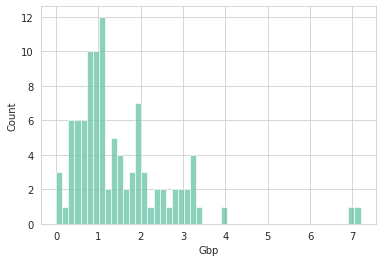

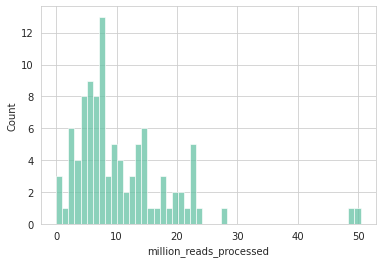

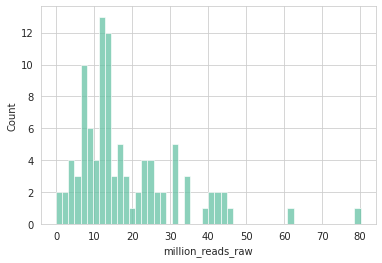

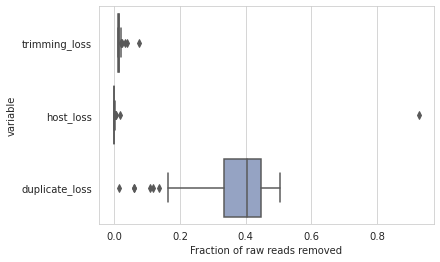

SampleName        variable     value
0      AK_SR_1   trimming_loss  0.032975
1      AK_SR_2   trimming_loss  0.020757
2    AK_SR_2.2   trimming_loss  0.015196
3      AK_SR_3   trimming_loss  0.012930
4      AK_SR_4   trimming_loss  0.013060
..         ...             ...       ...
295      TS8_B  duplicate_loss  0.421627
296     TS12_A  duplicate_loss  0.332360
297     TS12_B  duplicate_loss  0.467128
298     TS14_A  duplicate_loss  0.200814
299     TS14_B  duplicate_loss  0.456414

[300 rows x 3 columns]

In [136]:
fig_loc = '/home/mattolm/user_data/OneOffs/Junk/'

Fdb = Bdb.copy()
Fdb['Gbp'] = Fdb['unique_bases'] / 1e9
Fdb['raw_Gbp'] = Fdb['raw_bases'] / 1e9
Fdb['million_reads_processed'] = (Fdb['unique_reads'] * 2) / 1e6
Fdb['million_reads_raw'] = (Fdb['raw_reads'] * 2) / 1e6

Fdb['trimming_loss'] = (Fdb['raw_reads'] - Fdb['trimmed_reads']) / Fdb['raw_reads']
Fdb['host_loss'] = Fdb['host_reads'] / Fdb['raw_reads']
Fdb['duplicate_loss'] = Fdb['duplicate_reads'] / Fdb['raw_reads']

sns.histplot(data=Fdb, x='Gbp', bins=50)
plt.gcf().savefig(fig_loc + 'IndianMicrobiome_Gbp.png', bbox_inches='tight')
plt.show()

sns.histplot(data=Fdb, x='million_reads_processed', bins=50)
plt.gcf().savefig(fig_loc + 'IndianMicrobiome_reads_processed.png', bbox_inches='tight')
plt.show()

sns.histplot(data=Fdb, x='million_reads_raw', bins=50)
plt.gcf().savefig(fig_loc + 'IndianMicrobiome_reads_raw.png', bbox_inches='tight')
plt.show()

Fdb = Fdb.melt(id_vars='SampleName', value_vars=['trimming_loss', 'host_loss', 'duplicate_loss'])
sns.boxplot(data=Fdb, x='value', y='variable')
plt.xlabel("Fraction of raw reads removed")
plt.gcf().savefig(fig_loc + 'IndianMicrobiome_reads_processing_loss.png', bbox_inches='tight')
plt.show()

Fdb


## Load new read locations

In [114]:
table = defaultdict(list)
for i, row in PPdb.iterrows():
    l_1 = f"s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/{row['sample']}/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_{row['sample']}_R1.fastq.gz"
    l_2 = f"s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/{row['sample']}/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_{row['sample']}_R2.fastq.gz"
    
    assert check_s3_file(l_1), l_1
    assert check_s3_file(l_2)
    
    table['sample'].append(row['sample'])
    table['read1'].append(l_1)
    table['read2'].append(l_2)
    
Ldb = pd.DataFrame(table)
Ldb


sample  \
0      AK_SR_1   
1      AK_SR_2   
2    AK_SR_2.2   
3      AK_SR_3   
4      AK_SR_4   
5      AK_SR_5   
6      AK_SR_6   
7      AK_SR_7   
8      AK_SR_8   
9      AK_SR_9   
10    AK_SR_10   
11  AK_SR_10.2   
12     AK_SW_1   
13     AK_SW_2   
14     AK_SW_3   
15     AK_SW_4   
16     AK_SW_5   
17     AK_SW_7   
18     AK_SW_8   
19     AK_SW_9   
20    AK_SW_11   
21    AK_SW_12   
22    AK_SW_14   
23     AK_SG_7   
24    AK_SG_10   
25    AK_SG_11   
26    AK_SG_16   
27    AK_SG_17   
28    AK_SG_19   
29    AK_SG_20   
30    AK_SG_22   
31    AK_SG_25   
32    AK_SG_26   
33    AK_SG_29   
34     AK_SG_2   
35     AK_SG_4   
36     AK_SG_5   
37     AK_SG_8   
38   AK_SG_8.2   
39     AK_SG_9   
40    AK_SG_12   
41    AK_SG_15   
42    AK_SG_18   
43    AK_SG_28   
44    AK_SK_10   
45    AK_SK_19   
46    AK_SK_32   
47    AK_SK_35   
48    AK_SK_44   
49     AK_SK_1   
50    AK_SK_11   
51    AK_SK_12   
52    AK_SK_13   
53    AK_SK_15   
54    AK_SK_24   
55    AK_SK_30   
56    AK_SK_33   
57    AK_SK_37   
58  AK_SK_49.2   
59     AK_SK_2   
60    AK_SK_18   
61    AK_SK_25   
62    AK_SK_26   
63    AK_SK_27   
64    AK_SK_38   
65    AK_SK_39   
66    AK_SK_45   
67    AK_SK_48   
68    AK_SK_49   
69     AK_SK_9   
70    AK_SK_14   
71    AK_SK_29   
72    AK_SK_34   
73    AK_SK_36   
74    AK_SK_47   
75  AK_SK_47.2   
76     AK_SK_8   
77    AK_SK_40   
78    AK_SK_17   
79     AK_SK_5   
80       RS1_A   
81       RS1_B   
82       RS5_A   
83       RS5_B   
84       RS8_A   
85       RS8_B   
86      RS12_A   
87      RS12_B   
88      RS14_A   
89      RS14_B   
90       TS1_A   
91       TS1_B   
92       TS5_A   
93       TS5_B   
94       TS8_A   
95       TS8_B   
96      TS12_A   
97      TS12_B   
98      TS14_A   
99      TS14_B   

                                                                                                                                 read1  \
0         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_1/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_1_R1.fastq.gz   
1         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_2/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_2_R1.fastq.gz   
2     s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_2.2/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_2.2_R1.fastq.gz   
3         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_3/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_3_R1.fastq.gz   
4         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_4/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_4_R1.fastq.gz   
5         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_5/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_5_R1.fastq.gz   
6         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_6/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_6_R1.fastq.gz   
7         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_7/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_7_R1.fastq.gz   
8         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_8/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_8_R1.fastq.gz   
9         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_9/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_9_R1.fastq.gz   
10      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_10/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_10_R1.fastq.gz   
11  s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_10.2/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_10.2_R1.fastq.gz   
12        s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SW_1/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SW_1_R1.fastq.gz   
13        s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SW_2/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SW_2_R1.fastq.gz   
14        s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SW_3/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_S

## Load new read locations

In [118]:
bdb = Bdb.rename(columns={'SampleName':'sample', 'unique_reads':'pairs', 'unique_bases':'bases', 'raw_reads':'raw_pairs'})
bdb = bdb[['sample', 'pairs', 'bases', 'raw_pairs', 'raw_bases']]
bdb['RL'] = (bdb['bases'] / bdb['pairs']) / 2

BPdb = pd.merge(PPdb, bdb, on='sample')
BPdb.head()


sample  \
0    AK_SR_1   
1    AK_SR_2   
2  AK_SR_2.2   
3    AK_SR_3   
4    AK_SR_4   

                                                                                              read1  \
0    s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A2_AK-SR-1_R1.fastq.gz   
1    s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A4_AK-SR-2_R1.fastq.gz   
2  s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-D2_AK-SR-2-2_R1.fastq.gz   
3    s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A6_AK-SR-3_R1.fastq.gz   
4    s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A8_AK-SR-4_R1.fastq.gz   

                                                                                              read2  \
0    s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A2_AK-SR-1_R2.fastq.gz   
1    s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A4_AK-SR-2_R2.fastq.gz   
2  s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-D2_AK-SR-2-2_R2.fastq.gz   
3    s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A6_AK-SR-3_R2.fastq.gz   
4    s3://czbiohub-microbiome/Sonnenburg_Lab/2021_Indian_Microbiome/LibPlate-A8_AK-SR-4_R2.fastq.gz   

             library_key  tribe  DNA_concentration sample_type fecal_sample  \
0    LibPlate-A2_AK-SR-1  Kabui               51.5       fecal          NaN   
1    LibPlate-A4_AK-SR-2  Kabui               28.7       fecal          NaN   
2  LibPlate-D2_AK-SR-2-2  Kabui               92.8       fecal          NaN   
3    LibPlate-A6_AK-SR-3  Kabui              411.8       fecal          NaN   
4    LibPlate-A8_AK-SR-4  Kabui               83.3       fecal          NaN   

      pairs       bases  raw_pairs    raw_bases          RL  
0  24276525  6938547858   40041788  11692202096  142.906529  
1  25189547  7192762783   30917233   9027832036  142.772770  
2  11357247  3183231459   20045323   5853234316  140.140980  
3   5682989  1595248519   11410676   3331917392  140.352948  
4   5552061  1578724021    6520759   1904061628  142.174593

In [119]:
PXdb = BPdb.copy()
for c in ['read1', 'read2']:
    del PXdb[c]
order = list(PXdb.columns)[1:]
PXdb = pd.merge(PXdb, Ldb)
PXdb = PXdb[['sample', 'read1', 'read2'] + order]
PXdb.head()


sample  \
0    AK_SR_1   
1    AK_SR_2   
2  AK_SR_2.2   
3    AK_SR_3   
4    AK_SR_4   

                                                                                                                              read1  \
0      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_1/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_1_R1.fastq.gz   
1      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_2/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_2_R1.fastq.gz   
2  s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_2.2/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_2.2_R1.fastq.gz   
3      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_3/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_3_R1.fastq.gz   
4      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_4/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_4_R1.fastq.gz   

                                                                                                                              read2  \
0      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_1/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_1_R2.fastq.gz   
1      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_2/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_2_R2.fastq.gz   
2  s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_2.2/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_2.2_R2.fastq.gz   
3      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_3/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_3_R2.fastq.gz   
4      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_4/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_4_R2.fastq.gz   

             library_key  tribe  DNA_concentration sample_type fecal_sample  \
0    LibPlate-A2_AK-SR-1  Kabui               51.5       fecal          NaN   
1    LibPlate-A4_AK-SR-2  Kabui               28.7       fecal          NaN   
2  LibPlate-D2_AK-SR-2-2  Kabui               92.8       fecal          NaN   
3    LibPlate-A6_AK-SR-3  Kabui              411.8       fecal          NaN   
4    LibPlate-A8_AK-SR-4  Kabui               83.3       fecal          NaN   

      pairs       bases  raw_pairs    raw_bases          RL  
0  24276525  6938547858   40041788  11692202096  142.906529  
1  25189547  7192762783   30917233   9027832036  142.772770  
2  11357247  3183231459   20045323   5853234316  140.140980  
3   5682989  1595248519   11410676   3331917392  140.352948  
4   5552061  1578724021    6520759   1904061628  142.174593

## Save


In [120]:
PXdb.to_csv(data_loc + 'IndianMicrobiome_basicinfo_v2.csv', index=False)
PXdb


sample  \
0      AK_SR_1   
1      AK_SR_2   
2    AK_SR_2.2   
3      AK_SR_3   
4      AK_SR_4   
5      AK_SR_5   
6      AK_SR_6   
7      AK_SR_7   
8      AK_SR_8   
9      AK_SR_9   
10    AK_SR_10   
11  AK_SR_10.2   
12     AK_SW_1   
13     AK_SW_2   
14     AK_SW_3   
15     AK_SW_4   
16     AK_SW_5   
17     AK_SW_7   
18     AK_SW_8   
19     AK_SW_9   
20    AK_SW_11   
21    AK_SW_12   
22    AK_SW_14   
23     AK_SG_7   
24    AK_SG_10   
25    AK_SG_11   
26    AK_SG_16   
27    AK_SG_17   
28    AK_SG_19   
29    AK_SG_20   
30    AK_SG_22   
31    AK_SG_25   
32    AK_SG_26   
33    AK_SG_29   
34     AK_SG_2   
35     AK_SG_4   
36     AK_SG_5   
37     AK_SG_8   
38   AK_SG_8.2   
39     AK_SG_9   
40    AK_SG_12   
41    AK_SG_15   
42    AK_SG_18   
43    AK_SG_28   
44    AK_SK_10   
45    AK_SK_19   
46    AK_SK_32   
47    AK_SK_35   
48    AK_SK_44   
49     AK_SK_1   
50    AK_SK_11   
51    AK_SK_12   
52    AK_SK_13   
53    AK_SK_15   
54    AK_SK_24   
55    AK_SK_30   
56    AK_SK_33   
57    AK_SK_37   
58  AK_SK_49.2   
59     AK_SK_2   
60    AK_SK_18   
61    AK_SK_25   
62    AK_SK_26   
63    AK_SK_27   
64    AK_SK_38   
65    AK_SK_39   
66    AK_SK_45   
67    AK_SK_48   
68    AK_SK_49   
69     AK_SK_9   
70    AK_SK_14   
71    AK_SK_29   
72    AK_SK_34   
73    AK_SK_36   
74    AK_SK_47   
75  AK_SK_47.2   
76     AK_SK_8   
77    AK_SK_40   
78    AK_SK_17   
79     AK_SK_5   
80       RS1_A   
81       RS1_B   
82       RS5_A   
83       RS5_B   
84       RS8_A   
85       RS8_B   
86      RS12_A   
87      RS12_B   
88      RS14_A   
89      RS14_B   
90       TS1_A   
91       TS1_B   
92       TS5_A   
93       TS5_B   
94       TS8_A   
95       TS8_B   
96      TS12_A   
97      TS12_B   
98      TS14_A   
99      TS14_B   

                                                                                                                                 read1  \
0         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_1/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_1_R1.fastq.gz   
1         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_2/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_2_R1.fastq.gz   
2     s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_2.2/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_2.2_R1.fastq.gz   
3         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_3/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_3_R1.fastq.gz   
4         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_4/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_4_R1.fastq.gz   
5         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_5/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_5_R1.fastq.gz   
6         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_6/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_6_R1.fastq.gz   
7         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_7/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_7_R1.fastq.gz   
8         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_8/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_8_R1.fastq.gz   
9         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_9/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_9_R1.fastq.gz   
10      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_10/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_10_R1.fastq.gz   
11  s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_10.2/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_10.2_R1.fastq.gz   
12        s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SW_1/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SW_1_R1.fastq.gz   
13        s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SW_2/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SW_2_R1.fastq.gz   
14        s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SW_3/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_S

In [139]:
(PXdb['raw_pairs'].mean() / 1e6) * 2

18.12619268

In [140]:
(PXdb['pairs'].mean() / 1e6) * 2

10.6668851

In [142]:
PXdb['bases'].mean() / 1e9

1.50223049375